## Google Drive and Glove Download

In [9]:
BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"

from google.colab import drive
drive.mount('/content/drive')


training_path = BASE_URL + 'data/processed/fakenews_training_processed.csv'
test_path = BASE_URL + 'data/processed/fakenews_test_processed.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional,Activation, Dropout,GlobalMaxPool1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras import utils

from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read Data & Tokenize

In [73]:
df_train = pd.read_csv(training_path)

In [74]:
df_test = pd.read_csv(test_path)

In [75]:
# Obtaining The Total Words Present In The Dataset
list_of_words = []
for doc in df_train.title_text:
  tokens = nltk.word_tokenize(doc)
  for j in tokens:
    list_of_words.append(j)

# Obtaining The Total Number Of Unique Words
total_words = len(list(set(list_of_words)))
total_words

24293

In [105]:
maxlen = -1
for doc in df_train.title_text:
  tokens = nltk.word_tokenize(doc)
  if(maxlen<len(tokens)):
    maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 3614


In [77]:
x_train,x_test,y_train,y_test = df_train.title_text, df_test.title_text, df_train.label, df_test.label

In [106]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  
print(vocab_size)
print(total_words)

24269
24293


In [107]:
#maxlen=1250
# Adding Padding
padded_train = pad_sequences(train_sequences ,maxlen = maxlen, padding='post')
padded_test = pad_sequences(test_sequences, maxlen = maxlen,padding='post') 

In [108]:
encoder = LabelEncoder()
encoder.fit(y_train)
train_y = encoder.transform(y_train)
test_y = encoder.transform(y_test)

num_classes = np.max(train_y) + 1
train_y = utils.to_categorical(train_y, num_classes)
test_y = utils.to_categorical(test_y, num_classes)

In [81]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Word Count


In [110]:
maxlen

3614

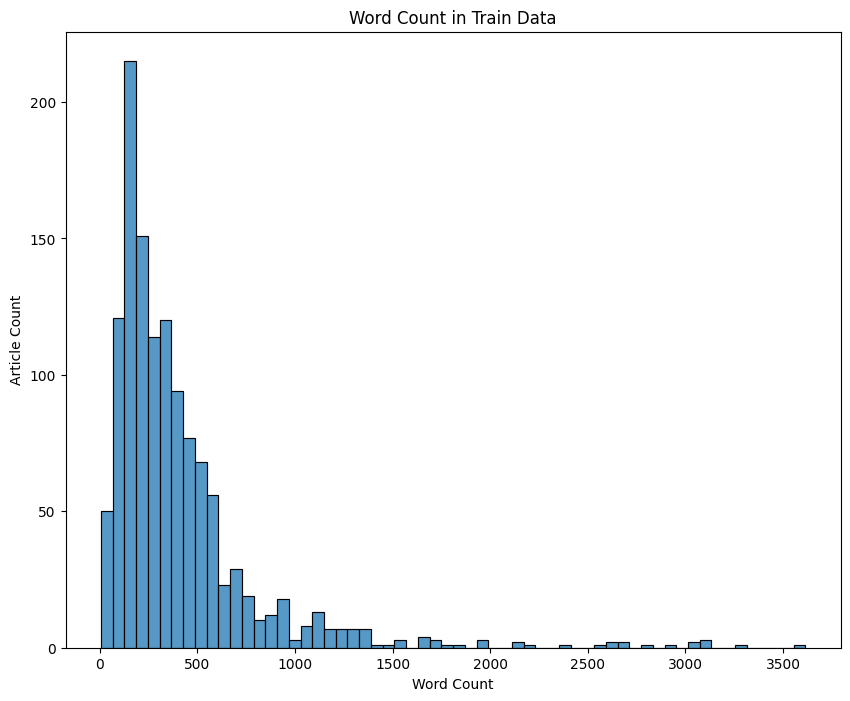

In [109]:
df_train['word_count'] = df_train['title_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_train, x='word_count')
plt.title('Word Count in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [88]:
train_articles = (sum(df_train['word_count'] < 1250)/df_train.shape[0])*100
print('Percentage of Training Articles having less than 1000 Words:{:.2f}%'.format(train_articles))

Percentage of Training Articles having less than 1000 Words:95.97%


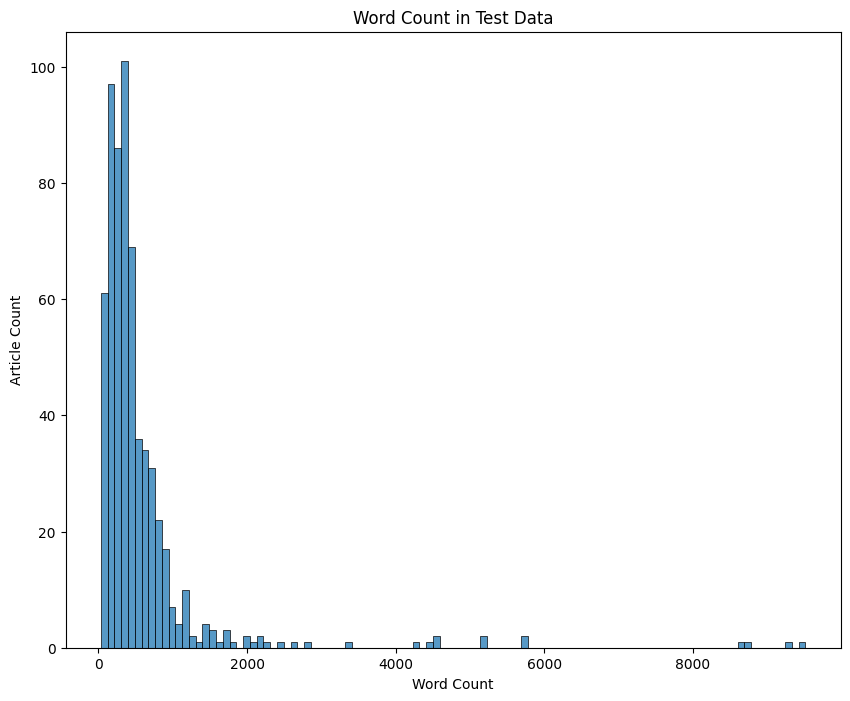

In [89]:
df_test['word_count'] = df_test['title_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,8))
sns.histplot(data=df_test, x='word_count')
plt.title('Word Count in Test Data')
plt.xlabel('Word Count')
plt.ylabel('Article Count')
plt.show()

In [90]:
test_articles = (sum(df_test['word_count'] < 1250)/df_test.shape[0])*100
print('Percentage of Test Articles having less than 1000 Words:{:.2f}%'.format(test_articles))

Percentage of Test Articles having less than 1000 Words:94.12%


# Embedding (Pretrained)

In [111]:
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab
 
# matrix for vocab: word_index
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)


# LR Finder

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [84]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr
  
  
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list 
  

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    
def plot_multiclass_roc_curves(classes, categories, X_test, y_proba, y_test):
  # Plots the Probability Distributions and the ROC Curves One vs Rest
  plt.figure(figsize = (9, 5))
  bins = [i/20 for i in range(20)] + [1]
  #classes = AdaBoost.classes_
  print(classes)
  roc_auc_ovr = {}
  for i in range(len(classes)):
      # Gets the class
      c = classes[i]      
      # Prepares an auxiliar dataframe to help with the plots
      df_aux = X_test.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_test]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)    
      
      # Plots the probability distribution for the class and the rest
      ax = plt.subplot(2, 4, i+1)
      sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
      ax.set_title(c)
      ax.legend([f"Class: {c}", "Rest"])
      ax.set_xlabel(f"P(x = {c})")
      
      # Calculates the ROC Coordinates and plots the ROC Curves
      ax_bottom = plt.subplot(2, 4, i+5)    
      tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
      plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
      ax_bottom.set_title(f"{categories[i]} - Rest")
      
      # Calculates the ROC AUC OvR
      roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
  plt.tight_layout()


  import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, start_from_epoch=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 5, factor = 0.5, min_lr = 0.000001)
adam_opt = Adam(learning_rate=0.05
                )

# Model 5

In [116]:
adam_opt = Adam(learning_rate=0.001
                ) 
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights = [embedding_matrix_vocab], trainable = False))
model5.add(Bidirectional(LSTM(32)))
model5.add(Dropout(0.3))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(4, activation='softmax'))
model5.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 3614, 100)         2426900   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                     

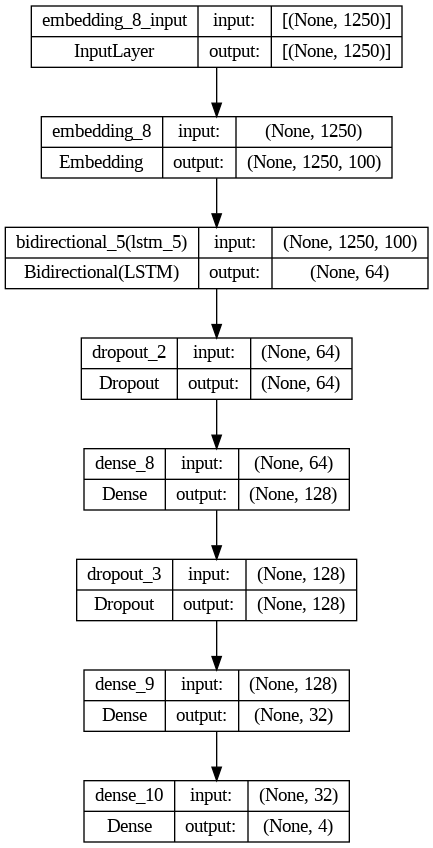

In [94]:
from keras.utils import plot_model
plot_model(model5, to_file='model_1.png', show_shapes=True, show_layer_names=True)

Epoch 1/20
10/10 [==============================] - 6s 63ms/step - loss: 1.4009 - accuracy: 0.2002
Epoch 2/20
10/10 [==============================] - 0s 43ms/step - loss: 1.3760 - accuracy: 0.3030
Epoch 3/20
10/10 [==============================] - 0s 41ms/step - loss: 1.3405 - accuracy: 0.4169
Epoch 4/20
10/10 [==============================] - 0s 42ms/step - loss: 1.2833 - accuracy: 0.4557
Epoch 5/20
10/10 [==============================] - 0s 42ms/step - loss: 1.2522 - accuracy: 0.4581
Epoch 6/20
10/10 [==============================] - 0s 41ms/step - loss: 1.2469 - accuracy: 0.4407
Epoch 7/20
10/10 [==============================] - 0s 42ms/step - loss: 1.2281 - accuracy: 0.4620
Epoch 8/20
10/10 [==============================] - 0s 41ms/step - loss: 1.2082 - accuracy: 0.4691
Epoch 9/20
10/10 [==============================] - 0s 42ms/step - loss: 1.1933 - accuracy: 0.4842
Epoch 10/20
10/10 [==============================] - 0s 42ms/step - loss: 1.1801 - accuracy: 0.4684
Epoch 11/

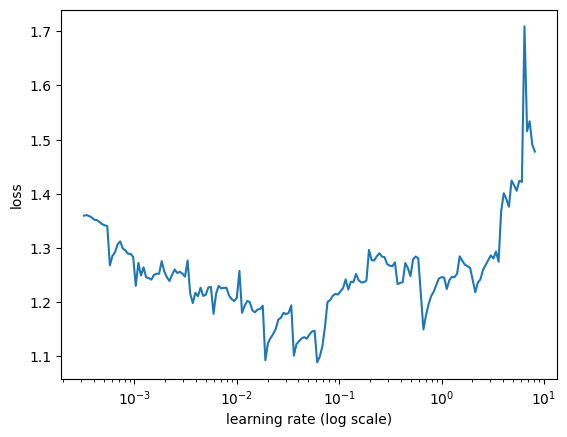

In [117]:
lr_finder = LRFinder(model5)
lr_finder.find(padded_train, y_train, start_lr=0.0001, end_lr=10, batch_size=128, epochs=20)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [117]:
#%load_ext tensorboard
#!rm -rf logs

#log_folder = 'logs'
#tb= TensorBoard(log_dir=log_folder)

history5 = model5.fit(padded_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(padded_test, y_test),
                    callbacks = [mc]) #tb

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.3030 - accuracy: 0.4446
Epoch 1: val_accuracy did not improve from 0.51471
10/10 [==============================] - 8s 395ms/step - loss: 1.3030 - accuracy: 0.4446 - val_loss: 1.1974 - val_accuracy: 0.5147
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.2508 - accuracy: 0.4573
Epoch 2: val_accuracy did not improve from 0.51471
10/10 [==============================] - 2s 239ms/step - loss: 1.2508 - accuracy: 0.4573 - val_loss: 1.2301 - val_accuracy: 0.5147
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.2437 - accuracy: 0.4573
Epoch 3: val_accuracy did not improve from 0.51471
10/10 [==============================] - 2s 238ms/step - loss: 1.2437 - accuracy: 0.4573 - val_loss: 1.2546 - val_accuracy: 0.5147
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.2321 - accuracy: 0.4549
Epoch 4: val_accuracy did not improve from 0.51471
10/10 [====================

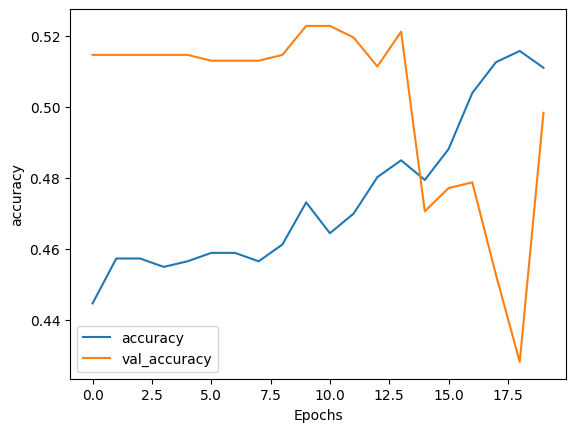

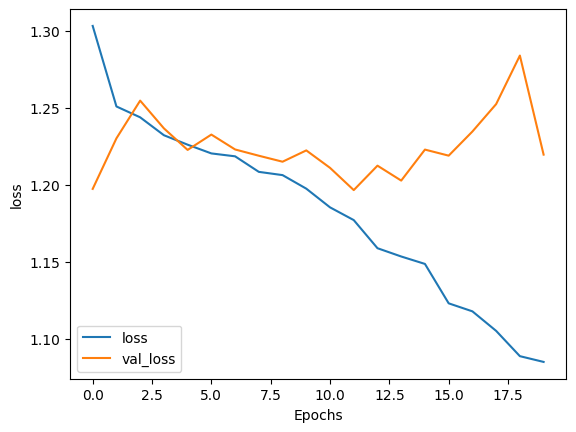

In [126]:
plot_graphs(history5, "accuracy")
plot_graphs(history5, "loss")

In [124]:
#Predict
y_prediction_5 = model5.predict(padded_test)
y_prediction_5 = np.argmax (y_prediction_5, axis = 1)
result_5 = confusion_matrix(y_test, y_prediction_5)

20/20 [==============================] - 3s 161ms/step


In [128]:
print(classification_report(y_test, y_prediction_5))

              precision    recall  f1-score   support

           0       0.57      0.88      0.69       315
           1       0.41      0.06      0.10       210
           2       0.16      0.27      0.20        56
           3       0.00      0.00      0.00        31

    accuracy                           0.50       612
   macro avg       0.29      0.30      0.25       612
weighted avg       0.45      0.50      0.41       612



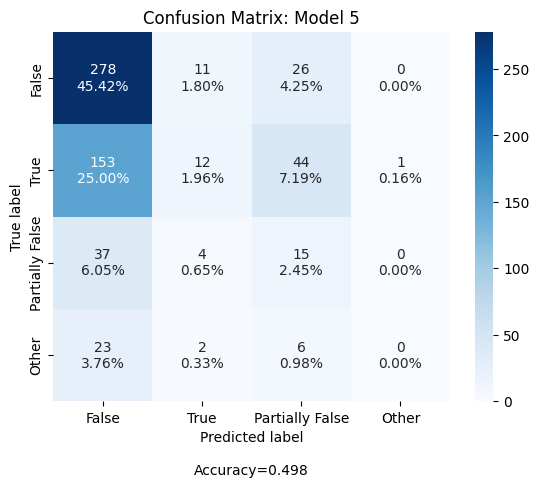

In [127]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result_5, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      #figsize=(5,5),
                      cbar=True, title='Confusion Matrix: Model 5', sum_stats=True)

# Model 6

In [112]:
adam_opt = Adam(learning_rate=0.001
                ) 
model6 = Sequential()
model6.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights = [embedding_matrix_vocab], trainable = False))
model6.add(Bidirectional(LSTM(128, dropout=0.2)))
model6.add(Dense(4, activation='softmax'))
model6.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model6.summary()

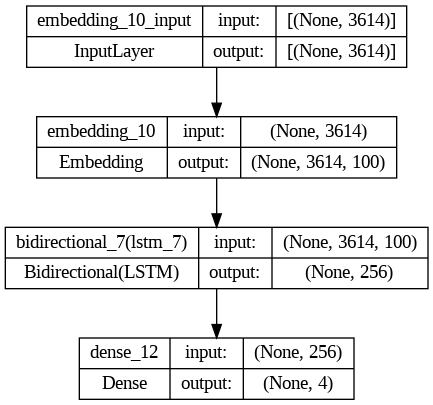

In [113]:
plot_model(model6, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [114]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, start_from_epoch=5)
#mc = ModelCheckpoint('best_model_6.h5', monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
#lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 5, factor = 0.5, min_lr = 0.000001)
#adam_opt = Adam(learning_rate=0.15)

history6 = model6.fit(padded_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(padded_test, y_test),
                    #callbacks = [es,mc]
                    ) #tb

Epoch 1/20
10/10 [==============================] - 9s 532ms/step - loss: 1.2730 - accuracy: 0.4233 - val_loss: 1.3624 - val_accuracy: 0.4706
Epoch 2/20
10/10 [==============================] - 5s 509ms/step - loss: 1.2355 - accuracy: 0.4612 - val_loss: 1.2099 - val_accuracy: 0.5098
Epoch 3/20
10/10 [==============================] - 4s 450ms/step - loss: 1.2148 - accuracy: 0.4628 - val_loss: 1.2510 - val_accuracy: 0.5049
Epoch 4/20
10/10 [==============================] - 5s 517ms/step - loss: 1.1934 - accuracy: 0.4684 - val_loss: 1.2444 - val_accuracy: 0.5049
Epoch 5/20
10/10 [==============================] - 5s 517ms/step - loss: 1.1800 - accuracy: 0.4684 - val_loss: 1.2479 - val_accuracy: 0.4951
Epoch 6/20
10/10 [==============================] - 5s 520ms/step - loss: 1.1680 - accuracy: 0.4960 - val_loss: 1.2638 - val_accuracy: 0.5033
Epoch 7/20
10/10 [==============================] - 5s 521ms/step - loss: 1.1491 - accuracy: 0.5047 - val_loss: 1.2850 - val_accuracy: 0.4984
Epoch 

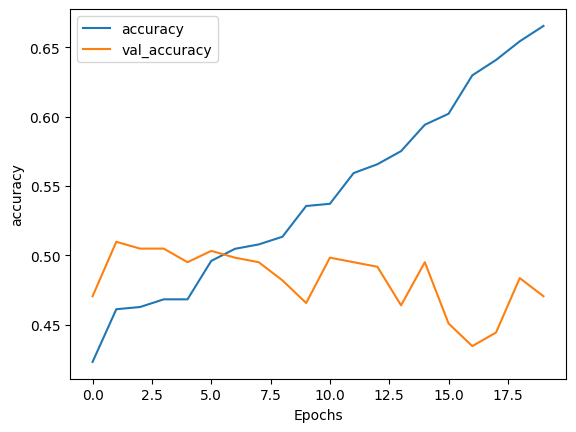

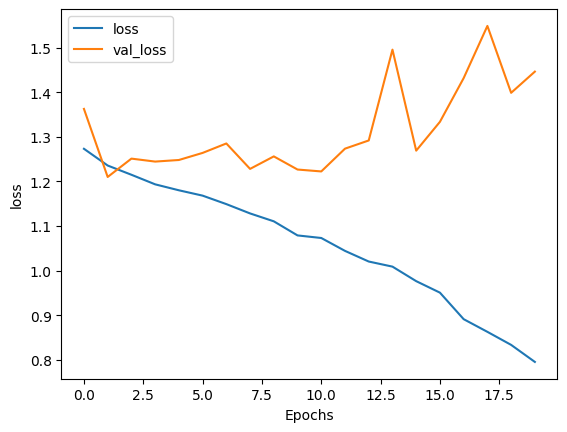

In [115]:
#model_best = keras.models.load_model('best_model.h5')
#loss, accuracy = model_best.evaluate(padded_train, y_train, verbose=False)
#print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = model_best.evaluate(padded_test, y_test, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_graphs(history6, "accuracy")
plot_graphs(history6, "loss")

In [ ]:
#Predict
y_prediction = model6.predict(padded_test)
y_prediction = np.argmax (y_prediction, axis = 1)
#y_test_1=np.argmax(y_test, axis=1)
result = confusion_matrix(y_test, y_prediction)

In [ ]:
print(classification_report(y_test, y_prediction))

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      #figsize=(5,5),
                      cbar=True, title='Confusion Matrix: Model 6', sum_stats=True)

In [ ]:
lr_finder = LRFinder(model6)
lr_finder.find(padded_train, y_train, start_lr=0.00001, end_lr=10, batch_size=128, epochs=20)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

# No Pretrain Method

In [99]:
embedding_dim = 128

adam= Adam(learning_rate=0.001)
model7 = Sequential()
model7.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model7.add(Bidirectional(LSTM(128, dropout=0.2)))
model7.add(Dense(4, activation='softmax'))
model7.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model7.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model7.summary()

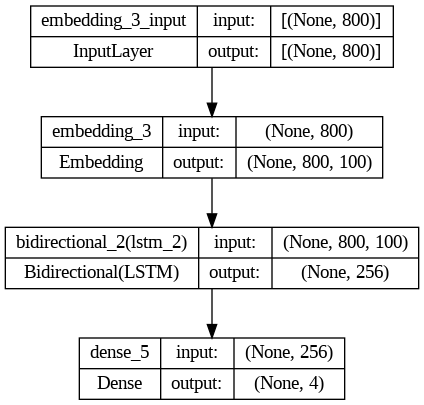

In [40]:
plot_model(model7, to_file='model_7.png', show_shapes=True, show_layer_names=True)

Epoch 1/20
10/10 [==============================] - 8s 282ms/step - loss: 1.3944 - accuracy: 0.1630
Epoch 2/20
10/10 [==============================] - 3s 271ms/step - loss: 1.3910 - accuracy: 0.1701
Epoch 3/20
10/10 [==============================] - 3s 268ms/step - loss: 1.3841 - accuracy: 0.2745
Epoch 4/20
10/10 [==============================] - 3s 346ms/step - loss: 1.3725 - accuracy: 0.4549
Epoch 5/20
10/10 [==============================] - 3s 324ms/step - loss: 1.3486 - accuracy: 0.4573
Epoch 6/20
10/10 [==============================] - 3s 279ms/step - loss: 1.2796 - accuracy: 0.4573
Epoch 7/20
10/10 [==============================] - 3s 262ms/step - loss: 1.2360 - accuracy: 0.4573
Epoch 8/20
10/10 [==============================] - 3s 272ms/step - loss: 1.2189 - accuracy: 0.4573
Epoch 9/20
10/10 [==============================] - 3s 340ms/step - loss: 1.1427 - accuracy: 0.4676
Epoch 10/20
10/10 [==============================] - 3s 297ms/step - loss: 0.9721 - accuracy: 0.6179

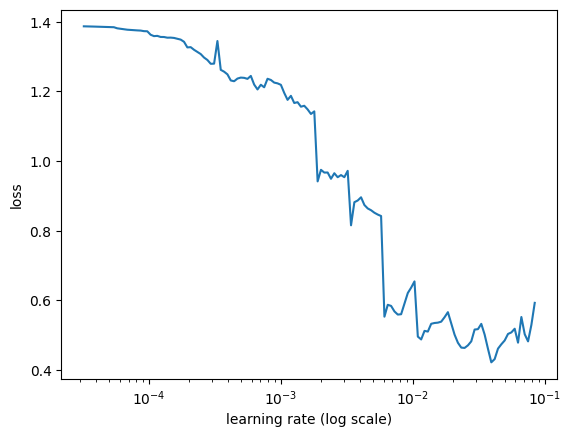

In [41]:
lr_finder = LRFinder(model7)
lr_finder.find(padded_train, train_y, start_lr=0.00001, end_lr=1, batch_size=128, epochs=20)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

In [100]:
history7 = model7.fit(padded_train, train_y,
                    batch_size=128,
                    epochs=20,
                    validation_data=(padded_test, test_y))

Epoch 1/20
10/10 [==============================] - 11s 578ms/step - loss: 1.3058 - accuracy: 0.4225 - val_loss: 1.2377 - val_accuracy: 0.5147
Epoch 2/20
10/10 [==============================] - 4s 367ms/step - loss: 1.2240 - accuracy: 0.4573 - val_loss: 1.2503 - val_accuracy: 0.5147
Epoch 3/20
10/10 [==============================] - 4s 363ms/step - loss: 1.1675 - accuracy: 0.4573 - val_loss: 1.2226 - val_accuracy: 0.5147
Epoch 4/20
10/10 [==============================] - 4s 359ms/step - loss: 1.0939 - accuracy: 0.4842 - val_loss: 1.2165 - val_accuracy: 0.5098
Epoch 5/20
10/10 [==============================] - 5s 479ms/step - loss: 0.9243 - accuracy: 0.6472 - val_loss: 1.4084 - val_accuracy: 0.3758
Epoch 6/20
10/10 [==============================] - 4s 357ms/step - loss: 0.7560 - accuracy: 0.6970 - val_loss: 1.3703 - val_accuracy: 0.4183
Epoch 7/20
10/10 [==============================] - 4s 356ms/step - loss: 0.6379 - accuracy: 0.7089 - val_loss: 1.4326 - val_accuracy: 0.4346
Epoch

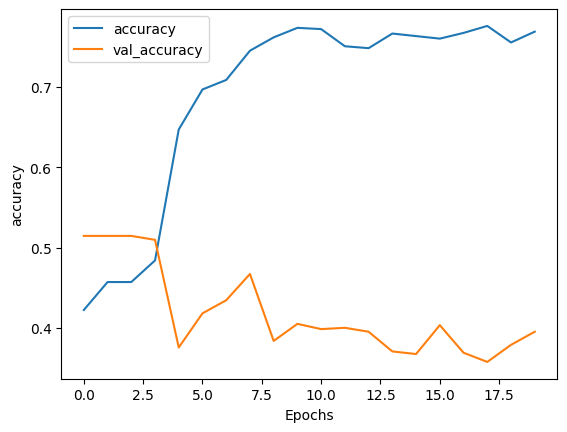

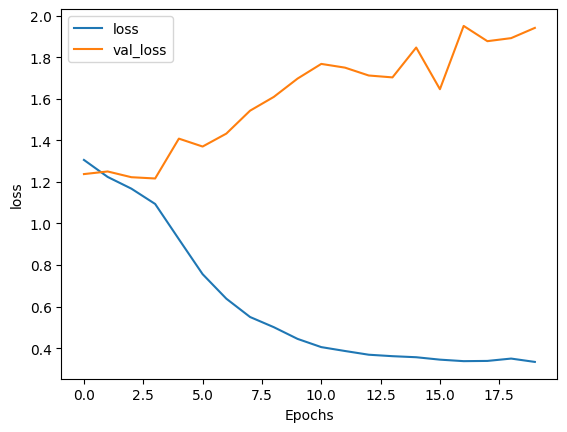

In [101]:
plot_graphs(history7, "accuracy")
plot_graphs(history7, "loss")

In [102]:
#Predict
y_prediction_7 = model7.predict(padded_test)
y_prediction_7 = np.argmax (y_prediction_7, axis = 1)
#y_test_1=np.argmax(y_test, axis=1)
result7 = confusion_matrix(y_test, y_prediction_7)

20/20 [==============================] - 2s 35ms/step


In [103]:
print(classification_report(y_test, y_prediction_7))

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       315
           1       0.41      0.11      0.18       210
           2       0.09      0.29      0.14        56
           3       0.08      0.10      0.09        31

    accuracy                           0.40       612
   macro avg       0.29      0.28      0.25       612
weighted avg       0.45      0.40      0.39       612



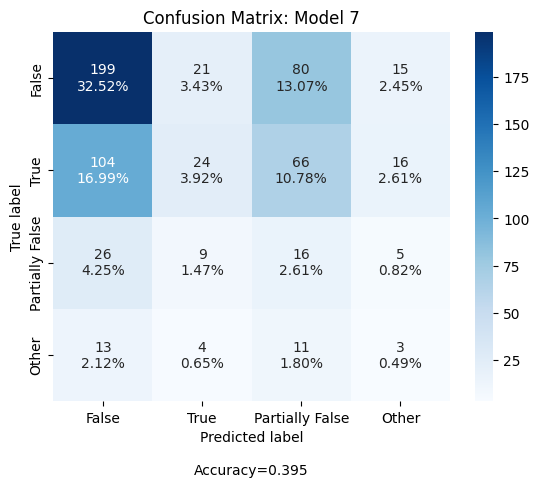

In [104]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result7, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      #figsize=(5,5),
                      cbar=True, title='Confusion Matrix: Model 7', sum_stats=True)